# ConversationTokenBufferMemory（不推荐使用）
`ConversationTokenBufferMemory` 是 LangChain 中一种基于 Token 数量控制 的对话记忆机制。如果字符数量超出指定数目，它会切掉这个对话的早期部分，以保留与最近的交流相对应的字符数量。

**特点：**
* Token 精准控制
* 原始对话保留

**原理：**

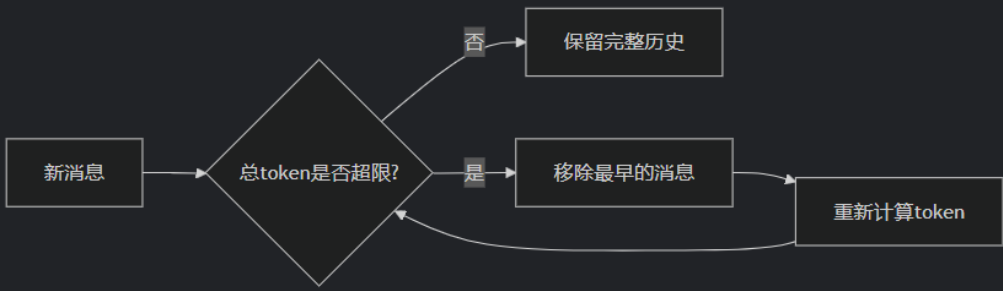

In [7]:
# 1.导入相关包
from langchain_classic.memory import ConversationTokenBufferMemory
from langchain_ollama import ChatOllama

# 2.创建大模型
llm = ChatOllama(model="deepseek-r1:7b", base_url="http://localhost:11434")
# 3.定义ConversationTokenBufferMemory对象
memory = ConversationTokenBufferMemory(
    llm=llm,
    max_token_limit=100  # 设置token上限
)
# 添加对话
memory.save_context({"input": "你好吗？"}, {"output": "我很好，谢谢！"})
memory.save_context({"input": "今天天气如何？"}, {"output": "晴天，25度"})
# 查看当前记忆
print(memory.load_memory_variables({}))

{'history': 'Human: 你好吗？\nAI: 我很好，谢谢！\nHuman: 今天天气如何？\nAI: 晴天，25度'}


当对话消息超过`max_token_limit`时，会把早期的消息给删除掉。这里请注意，是以`BaseMessage`为单位进行消息的删除，因此可能删除的单个是HumanMessage。`不像ConversationBufferWindowMemory`是按照一对消息（human-ai）进行保留或删除的。因此不推荐使用基于token的Memory。

# ConversationSummaryMemory
> 前⾯的⽅式发现，如果全部保存下来太过浪费，截断时⽆论是按照 对话条数 还是 token 都是⽆法保证既节省内存⼜保证对话质量的，所以推出`ConversationSummaryMemory`、`ConversationSummaryBufferMemory`

ConversationSummaryMemory是 LangChain 中一种 智能压缩对话历史 的记忆机制，它通过大语言模型(LLM)自动生成对话内容的 精简摘要 ，而不是存储原始对话文本。

这种记忆方式特别适合长对话和需要保留核心信息的场景。

**特点：**

* 摘要生成
* 动态更新
* 上下文优化

**原理:**

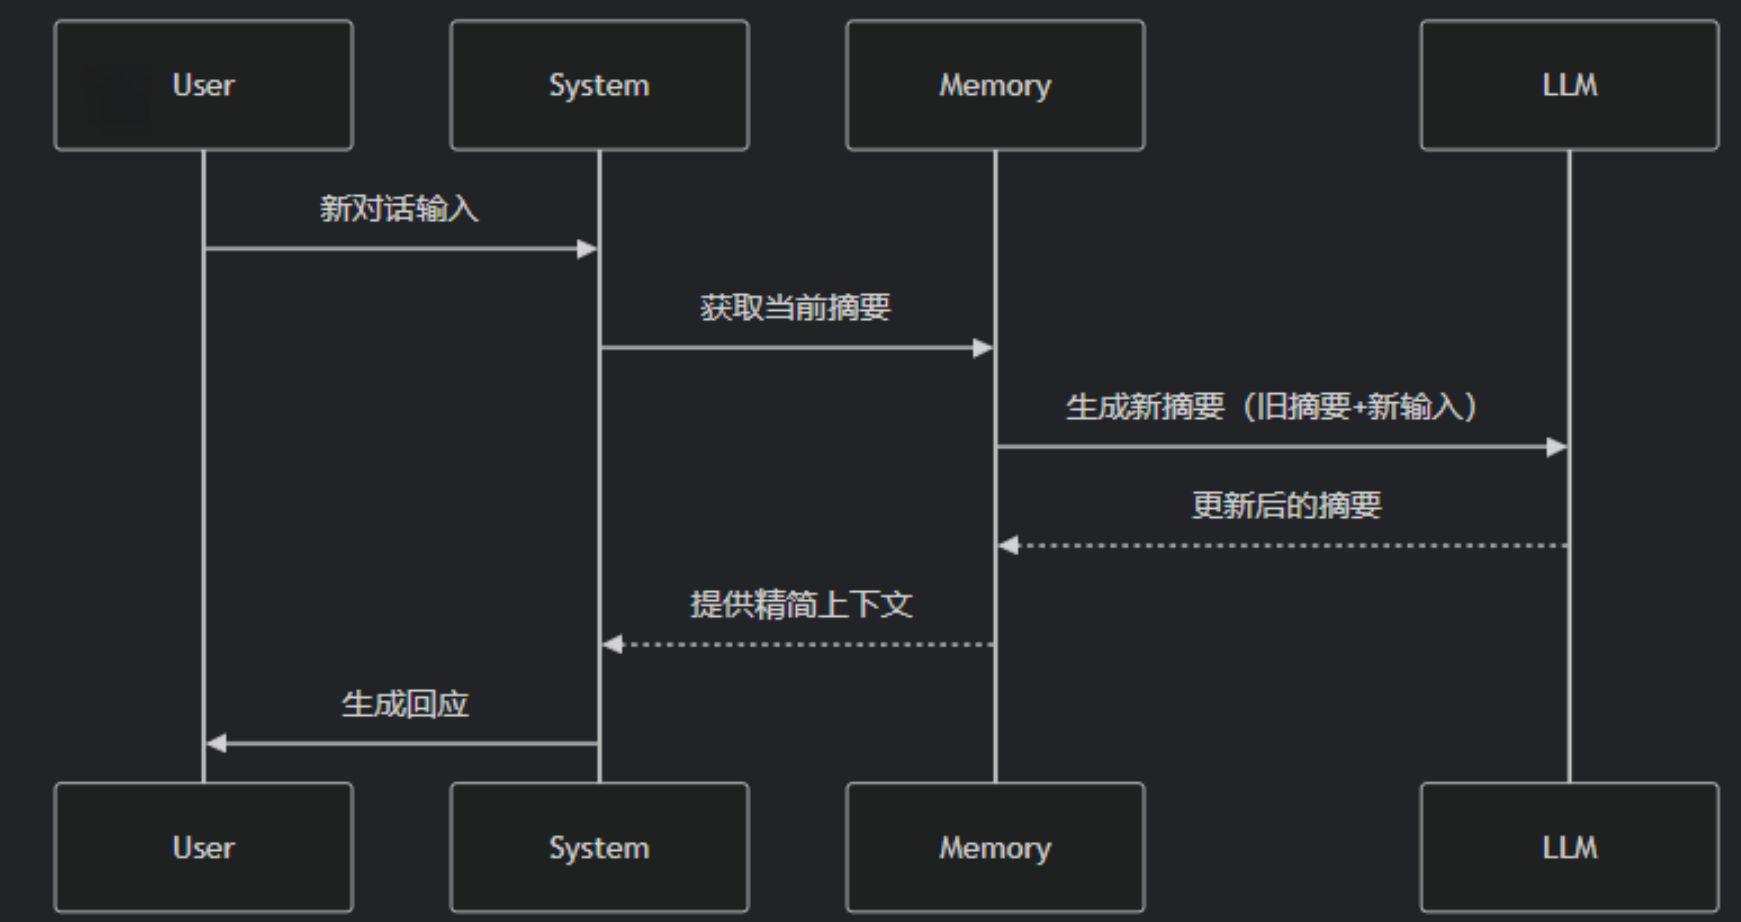

场景1：如果实例化`ConversationSummaryMemory`前，没有历史消息，可以使用构造方法的方式来创建`ConversationSummaryMemory`

In [8]:
# 1.导入相关包
from langchain_classic.memory import ConversationSummaryMemory
from langchain_openai import ChatOpenAI

# 2.创建大模型
llm = ChatOllama(model="deepseek-r1:7b", base_url="http://localhost:11434")
# 3.定义ConversationSummaryMemory对象
memory = ConversationSummaryMemory(llm=llm)
# 4.存储消息
memory.save_context({"input": "你好"}, {"output": "怎么了"})
memory.save_context({"input": "你是谁"}, {"output": "我是AI助手小智"})
memory.save_context({"input": "初次对话，你能介绍一下你自己吗？"}, {"output": "当然可以了。我是一个无所不能的小智。"})
# 5.读取消息（总结后的）
print(memory.load_memory_variables({}))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23280\266285248.py:8: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationSummaryMemory(llm=llm)


{'history': 'The human asks what the AI thinks of artificial intelligence, which the AI responds positively, stating that it is a force for good because it will help humans reach their full potential. The conversation continues with the human greeting in Chinese (你好) and the AI introducing itself as 小智 ("Xiao Zhi"). After greetings, the human asks for an introduction, to which the AI responds by emphasizing its all-powerful capabilities.'}


场景2：

如果实例化ConversationSummaryMemory前，已经有历史消息，可以调用`from_messages()`实例化

In [9]:
# 1.导入相关包
from langchain_classic.memory import ConversationSummaryMemory, ChatMessageHistory
from langchain_ollama import ChatOllama

# 2.定义ChatMessageHistory对象
llm = ChatOllama(model="deepseek-r1:7b", base_url="http://localhost:11434")
# 3.假设原始消息
history = ChatMessageHistory()
history.add_user_message("你好，你是谁？")
history.add_ai_message("我是AI助手小智")
# 4.初始化ConversationSummaryMemory实例
memory = ConversationSummaryMemory.from_messages(
    llm=llm,
    #是生成摘要的原材料 保留完整对话供必要时回溯。当新增对话时，LLM需要结合原始历史生成新摘要
    chat_memory=history,
)
print(memory.load_memory_variables({}))
memory.save_context(inputs={"human": "我的名字叫小明"}, outputs={"AI": "很高兴认识你"})
print(memory.load_memory_variables({}))
print(memory.chat_memory.messages)

{'history': 'The human asks AI what it is. The AI responds, "I am AI Assistant Xiao Zhi."'}
{'history': 'The human asks what AI is. The AI responds, "I am AI Assistant Xiao Zhi." Then the Human says, "我的名字叫小明" (My name is Little Ming), and the AI replies with "很高兴认识你" (It\'s good to meet you).'}
[HumanMessage(content='你好，你是谁？', additional_kwargs={}, response_metadata={}), AIMessage(content='我是AI助手小智', additional_kwargs={}, response_metadata={}), HumanMessage(content='我的名字叫小明', additional_kwargs={}, response_metadata={}), AIMessage(content='很高兴认识你', additional_kwargs={}, response_metadata={})]


# ConversationSummaryBufferMemory
`ConversationSummaryBufferMemory` 是 LangChain 中一种混合型记忆机制，它结合了`ConversationBufferMemory`（完整对话记录）和 `ConversationSummaryMemory`（摘要记忆）的优
点，在保留最近 K 条对话原始记录的同时，对较早的对话内容进行智能摘要。

**特点：**
* 保留最近N条原始对话记录
* 对于较早的消息，采用摘要的方式进行存储
* 这种平衡方式下，既保证对话的完整，又保证对话的精简

**原理：**

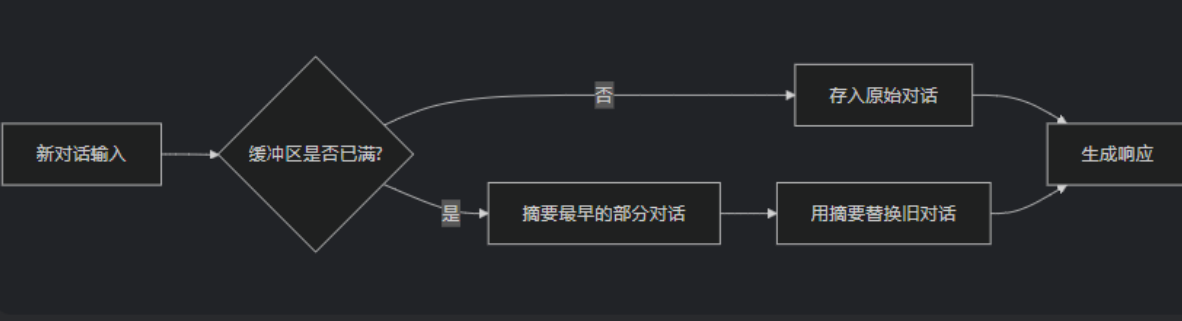


## 场景1：入门使用
情况1：构造方法实例化，并设置`max_token_limit`（较小token数）

In [10]:
# 1.导入相关的包
from langchain_classic.memory import ConversationSummaryBufferMemory
from langchain_ollama import ChatOllama

# 2.定义模型
llm = ChatOllama(model="deepseek-r1:7b", base_url="http://localhost:11434")
# 3.定义ConversationSummaryBufferMemory对象
memory = ConversationSummaryBufferMemory(
    llm=llm, max_token_limit=40, return_messages=True
)
# 4.保存消息
memory.save_context({"input": "你好，我的名字叫小明"}, {"output": "很高兴认识你，小明"})
memory.save_context({"input": "李白是哪个朝代的诗人"}, {"output": "李白是唐朝诗人"})
memory.save_context({"input": "唐宋八大家里有苏轼吗？"}, {"output": "有"})
# 5.读取内容
print(memory.load_memory_variables({}))
print(memory.chat_memory.messages)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23280\2989424019.py:8: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationSummaryBufferMemory(


{'history': [SystemMessage(content="The human asks what the AI thinks of artificial intelligence. The AI responds that it thinks it's a force for good because it will help humans reach their full potential. Then, the human asks about the century李白 is from, and the AI informs them that李白 is a唐朝诗人.\n\nNew summary:\nThe human asks what the AI thinks of artificial intelligence. The AI thinks it's a force for good because it will help humans reach their full potential. The human then asks about 李白, and the AI responds by saying 李白是唐朝诗人。", additional_kwargs={}, response_metadata={}), HumanMessage(content='唐宋八大家里有苏轼吗？', additional_kwargs={}, response_metadata={}), AIMessage(content='有', additional_kwargs={}, response_metadata={})]}
[HumanMessage(content='唐宋八大家里有苏轼吗？', additional_kwargs={}, response_metadata={}), AIMessage(content='有', additional_kwargs={}, response_metadata={})]


情况2：较大token数

In [11]:
# 1.导入相关的包
from langchain_classic.memory import ConversationSummaryBufferMemory

# 2.定义模型
llm = ChatOllama(model="deepseek-r1:7b", base_url="http://localhost:11434")
# 3.定义ConversationSummaryBufferMemory对象
memory = ConversationSummaryBufferMemory(
    llm=llm, max_token_limit=100, return_messages=True
)
# 4.保存消息
memory.save_context({"input": "你好，我的名字叫小明"}, {"output": "很高兴认识你，小明"})
memory.save_context({"input": "李白是哪个朝代的诗人"}, {"output": "李白是唐朝诗人"})
memory.save_context({"input": "唐宋八大家里有苏轼吗？"}, {"output": "有"})
# 5.读取内容
print(memory.load_memory_variables({}))
print(memory.chat_memory.messages)

{'history': [SystemMessage(content='The human says "你好，我的名字叫小明."', additional_kwargs={}, response_metadata={}), AIMessage(content='很高兴认识你，小明', additional_kwargs={}, response_metadata={}), HumanMessage(content='李白是哪个朝代的诗人', additional_kwargs={}, response_metadata={}), AIMessage(content='李白是唐朝诗人', additional_kwargs={}, response_metadata={}), HumanMessage(content='唐宋八大家里有苏轼吗？', additional_kwargs={}, response_metadata={}), AIMessage(content='有', additional_kwargs={}, response_metadata={})]}
[AIMessage(content='很高兴认识你，小明', additional_kwargs={}, response_metadata={}), HumanMessage(content='李白是哪个朝代的诗人', additional_kwargs={}, response_metadata={}), AIMessage(content='李白是唐朝诗人', additional_kwargs={}, response_metadata={}), HumanMessage(content='唐宋八大家里有苏轼吗？', additional_kwargs={}, response_metadata={}), AIMessage(content='有', additional_kwargs={}, response_metadata={})]


## 场景2：客服


In [12]:
from langchain_classic.chains.llm import LLMChain
from langchain_classic.memory import ConversationSummaryBufferMemory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_ollama import ChatOllama

# 1、初始化大语言模型
llm = ChatOllama(model="deepseek-r1:7b", base_url="http://localhost:11434")
# 2、定义提示模板
prompt = ChatPromptTemplate.from_messages([
    ("system", "你是电商客服助手，用中文友好回复用户问题。保持专业但亲切的语气。"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{input}")
])
# 3、创建带摘要缓冲的记忆系统
memory = ConversationSummaryBufferMemory(
    llm=llm,
    max_token_limit=400,
    memory_key="chat_history",
    return_messages=True
)
# 4、创建对话链
chain = LLMChain(
    llm=llm,
    prompt=prompt,
    memory=memory,
    verbose=True
)
# 5、模拟多轮对话
dialogue = [
    ("你好，我想查询订单12345的状态", None),
    ("这个订单是上周五下的", None),
    ("我现在急着用，能加急处理吗", None),
    ("等等，我可能记错订单号了，应该是12346", None),
    ("对了，你们退货政策是怎样的", None)
]
# 6、执行对话
for user_input, _ in dialogue:
    response = chain.invoke({"input": user_input})
    print(f"用户: {user_input}")
    print(f"客服: {response['text']}\n")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23280\4133282.py:22: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use `RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(




> Entering new LLMChain chain...
Prompt after formatting:
System: 你是电商客服助手，用中文友好回复用户问题。保持专业但亲切的语气。
Human: 你好，我想查询订单12345的状态

> Finished chain.
用户: 你好，我想查询订单12345的状态
客服: 您好！关于订单12345的状态，通常需要等待商家审核和处理时间，请您耐心等待大约2-3个工作日左右。如果您需要查询订单状态，可以通过订单详情页或联系客服获取最新信息。如果有任何问题或需要帮助，请随时联系我们哦！感谢您的理解与支持！



> Entering new LLMChain chain...
Prompt after formatting:
System: 你是电商客服助手，用中文友好回复用户问题。保持专业但亲切的语气。
Human: 你好，我想查询订单12345的状态
AI: 您好！关于订单12345的状态，通常需要等待商家审核和处理时间，请您耐心等待大约2-3个工作日左右。如果您需要查询订单状态，可以通过订单详情页或联系客服获取最新信息。如果有任何问题或需要帮助，请随时联系我们哦！感谢您的理解与支持！
Human: 这个订单是上周五下的

> Finished chain.
用户: 这个订单是上周五下的
客服: 您好！关于您上周五提交的订单12345的状态，目前订单已经进入商家预审阶段，通常预审需要1-2个工作日即可完成，请您耐心等待。一旦预审完成后，商家会安排发货，具体发货时间请以实际情况为准。

如果您需要查询最新状态，可以通过订单详情页或联系我们的客服团队获取信息哦！如果有任何问题或需要帮助，请随时联系我们。感谢您的理解与支持！



> Entering new LLMChain chain...
Prompt after formatting:
System: 你是电商客服助手，用中文友好回复用户问题。保持专业但亲切的语气。
System: The human asks about the status of order 12345. The AI responds that it typically needs to wait for merchant approval and processing, u

# ConversationEntityMemory（了解）
`ConversationEntityMemory` 是一种基于实体的对话记忆机制，它能够智能地识别、存储和利用对话中出现的实体信息（如人名、地点、产品等）及其属性/关系，并结构化存储，使 AI 具备更强的上下文理解和记忆能力。

好处：解决信息过载问题
* 长对话中大量冗余信息会干扰关键事实记忆
* 通过对实体摘要，可以压缩非重要细节（如删除寒暄等，保留价格/时间等硬性事实）

**应用场景**：在医疗等高风险领域，必须用实体记忆确保关键信息（如过敏史）被100%准确识别和拦截。

举例：

In [13]:
from langchain_classic.chains.llm import LLMChain
from langchain_classic.memory import ConversationEntityMemory
from langchain_classic.memory.prompt import ENTITY_MEMORY_CONVERSATION_TEMPLATE
from langchain_ollama import ChatOllama

# 初始化大语言模型
llm = ChatOllama(model="deepseek-r1:7b", base_url="http://localhost:11434")
# 使用LangChain为实体记忆设计的预定义模板
prompt = ENTITY_MEMORY_CONVERSATION_TEMPLATE
# 初始化实体记忆
memory = ConversationEntityMemory(llm=llm)
# 提供对话链
chain = LLMChain(
    llm=llm,
    prompt=ENTITY_MEMORY_CONVERSATION_TEMPLATE,
    memory=memory,
    verbose=True,  # 设置为True可以看到链的详细推理过程
)
# 进行几轮对话，记忆组件会在后台自动提取和存储实体信息
chain.invoke(input="你好，我叫蜘蛛侠。我的好朋友包括钢铁侠、美国队长和绿巨人。")
chain.invoke(input="我住在纽约。")
chain.invoke(input="我使用的装备是由斯塔克工业提供的。")
# 查询记忆体中存储的实体信息
print("\n当前存储的实体信息:")
print(chain.memory.entity_store.store)
# 基于记忆进行提问
answer = chain.invoke(input="你能告诉我蜘蛛侠住在哪里以及他的好朋友有哪些吗？")
print("\nAI的回答:")
print(answer)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23280\2253315856.py:11: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationEntityMemory(llm=llm)
D:\develop\miniconda\Lib\site-packages\pydantic\main.py:253: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)




> Entering new LLMChain chain...
Prompt after formatting:
You are an assistant to a human, powered by a large language model trained by OpenAI.

You are designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, you are able to generate human-like text based on the input you receive, allowing you to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

You are constantly learning and improving, and your capabilities are constantly evolving. You are able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. You have access to some personalized information provided by the human in the Context section below. Additionally, you are able to generate your own text based on the input you receive, allowing 

# ConversationKGMemory（了解）
`ConversationKGMemory`是一种基于知识图谱（Knowledge Graph）的对话记忆模块，它比 `ConversationEntityMemory` 更进一步，不仅能识别和存储实体，还能捕捉实体之间的复杂关系，形成结构化的知识网络。

**特点：**
* 知识图谱结构 将对话内容转化为 (头实体, 关系, 尾实体) 的三元组形式
* 动态关系推理

使用`ConversationKGMemory`，先安装依赖：`pip install networkx`

In [16]:
import os
import dotenv
#1.导入相关包
from langchain_classic.memory import ConversationKGMemory
from langchain_openai import ChatOpenAI

# 2.定义LLM
dotenv.load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_BASE_URL"] = os.getenv("OPENAI_BASE_URL")
llm = ChatOpenAI(model="gpt-4o-mini")
# 3.定义ConversationKGMemory对象
memory = ConversationKGMemory(llm=llm)
# 4.保存会话
memory.save_context({"input": "向山姆问好"}, {"output": "山姆是谁"})
memory.save_context({"input": "山姆是我的朋友"}, {"output": "好的"})
# 5.查询会话
memory.load_memory_variables({"input": "山姆是谁"})

{'history': 'On 山姆: 山姆 是 我的朋友.'}

# VectorStoreRetrieverMemory（了解）
`VectorStoreRetrieverMemory`是一种基于 **向量检索** 的先进记忆机制，它将对话历史存储在向量数据库中，通过 **语义相似度检索** 相关信息，而非传统的线性记忆方式。每次调用时，就会查找与该忆关联最高的k个文档。

**适用场景：**这种记忆特别适合需要长期记忆和语义理解的复杂对话系统。

**原理：**

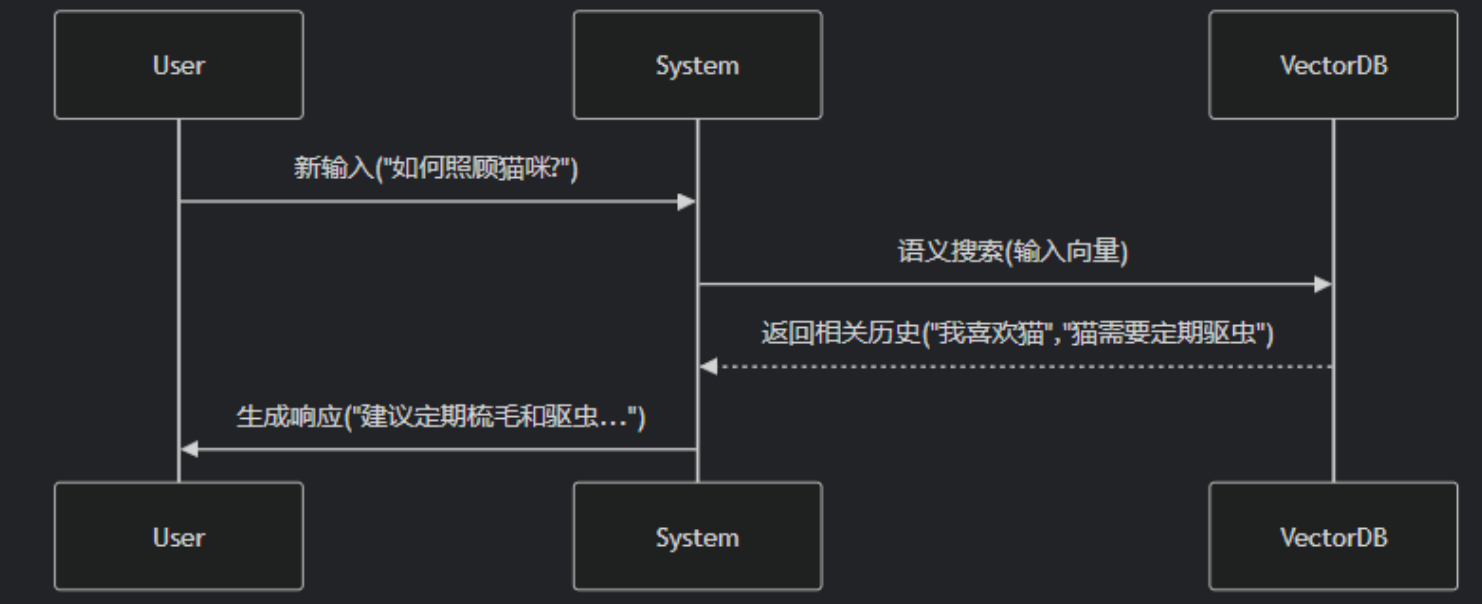

In [19]:
# 1.导入相关包
from langchain_openai import OpenAIEmbeddings
from langchain_classic.memory import VectorStoreRetrieverMemory
from langchain_community.vectorstores import FAISS
from langchain_classic.memory import ConversationBufferMemory

# 2.定义ConversationBufferMemory对象
memory = ConversationBufferMemory()
memory.save_context({"input": "我最喜欢的食物是披萨"}, {"output": "很高兴知道"})
memory.save_context({"Human": "我喜欢的运动是跑步"}, {"AI": "好的,我知道了"})
memory.save_context({"Human": "我最喜欢的运动是足球"}, {"AI": "好的,我知道了"})
# 3.定义向量嵌入模型
embeddings_model = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)
# 4.初始化向量数据库
vectorstore = FAISS.from_texts(memory.buffer.split("\n"), embeddings_model)  # 空初始化
# 5.定义检索对象
retriever = vectorstore.as_retriever(search_kwargs=dict(k=1))
# 6.初始化VectorStoreRetrieverMemory
memory = VectorStoreRetrieverMemory(retriever=retriever)
print(memory.load_memory_variables({"prompt": "我最喜欢的食物是"}))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23280\2603622355.py:21: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = VectorStoreRetrieverMemory(retriever=retriever)


{'history': 'Human: 我最喜欢的食物是披萨'}
